# Tidied up version of the predictive model

- [ACF, PCAF and stationarity](#acf_pacf)
- [Testing some models by the ACF and PACF analysis (AIC score)](#testing_models_1)
- [Best SARIMA model and test set comparison](#plot_best_sarima)
- [Best SARIMA model and test set comparison after walking-forward validation](#walk_forward_val)
- [Anomalies Identification in the timeseries](#anomaly_identification)
    - [A qualitative approach](#qualitative_approach)
    - [A quantitative approach](#quantitative_approach)
    - [Spotting the anomalies within 3$\sigma$](#spotting_3sigma)
- [A new dataset: correcting the anomaly points](#new_dataset)
- [The new prediction](#new_prediction)
- [RMSE comparison between the old and the corrected data training sets](#rmse_comparison)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

<a id='acf_pacf'></a>
## Checking ACF, PCAF and the stationarity

Here we analyze the ACF and the PCAF for the identification
of the SARIMA model's parameter. We also investigate the stationarity
by the Augmented Dicker Fuller test. We do the latter for the dataset
itself, its first difference and its seasonal difference.

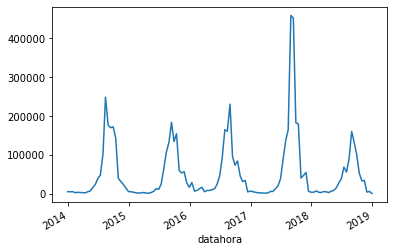

In [2]:
df2014 = pd.read_csv('../../sm-dataset/data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../sm-dataset/data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../sm-dataset/data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../sm-dataset/data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../sm-dataset/data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2014, df2015, df2016, df2017, df2018]).sort_index()

df_all = df_all.groupby(df_all.index).sum()

df_all = df_all.asfreq('SM')

df_all.riscofogo.plot()

plt.show()

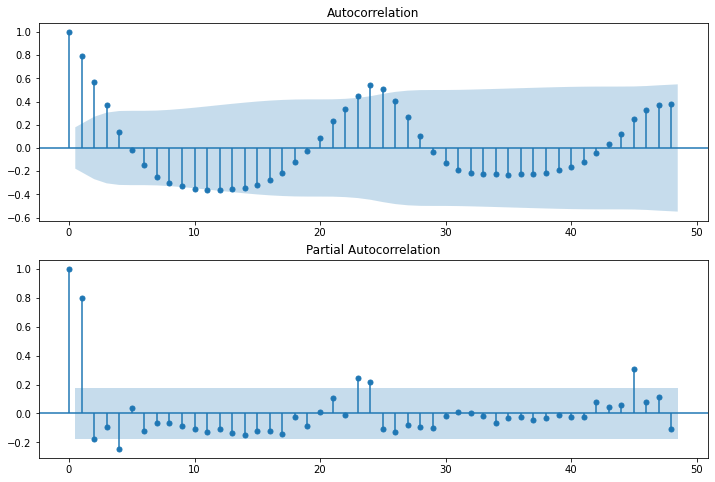

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=48,ax=ax1)
plot_pacf(df_all.dropna(),lags=48,ax=ax2)

plt.show()

#(1-4, 0, 2-3)(2-3, 0, 1, 24)

In [4]:
## Testing the stationarity

stationary_test = adfuller(df_all.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

ADF statistics : -4.836483751455998
p-value : 4.628807008490112e-05


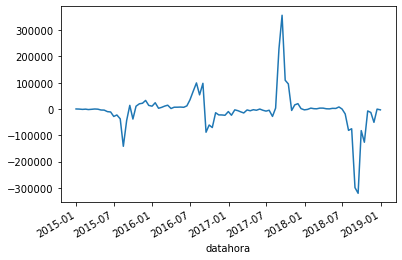

In [3]:
seasonal_diff = df_all - df_all.shift(24)

seasonal_diff.riscofogo.plot()

plt.show()

In [6]:
stationary_test = adfuller(seasonal_diff.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

ADF statistics : -4.425308160841153
p-value : 0.000267671700767426


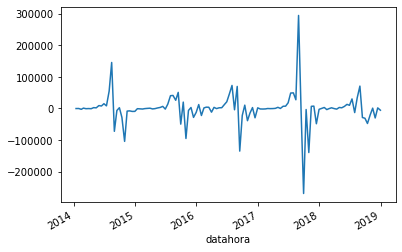

ADF statistics : -10.257408442784513
p-value : 4.324833919703425e-18


In [7]:
# biweekly difference

biweekly_diff = df_all - df_all.shift(1)

biweekly_diff.riscofogo.plot()

plt.show()
stationary_test = adfuller(biweekly_diff.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


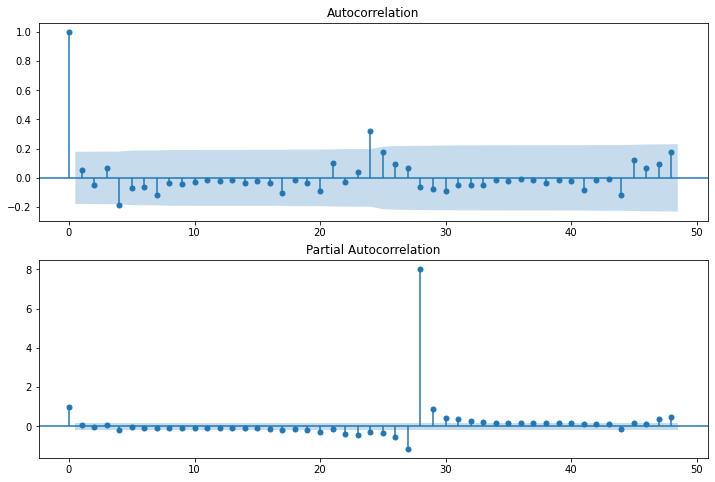

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(biweekly_diff.dropna(),lags=48,ax=ax1)
plot_pacf(biweekly_diff.dropna(),lags=48,ax=ax2)

plt.show()

We observe that the stationarity of the biweekly difference data is much more
stronger than the original or seasonal difference data. Also, there is a much
faster decay of the ACF in the biweekly data than the previous ones.

However, let's stick with the analysis of the original data and we might come
to these other differences data later.

By analyzing the PACF and the ACF we get the the seasonal ARIMA parameters
$p = 1-4$, $d = 0-1$, $q = 2-3$, $P = 2$ or more, $D = 0$ and $Q = 1-2$. Let's check
which one is the best model.

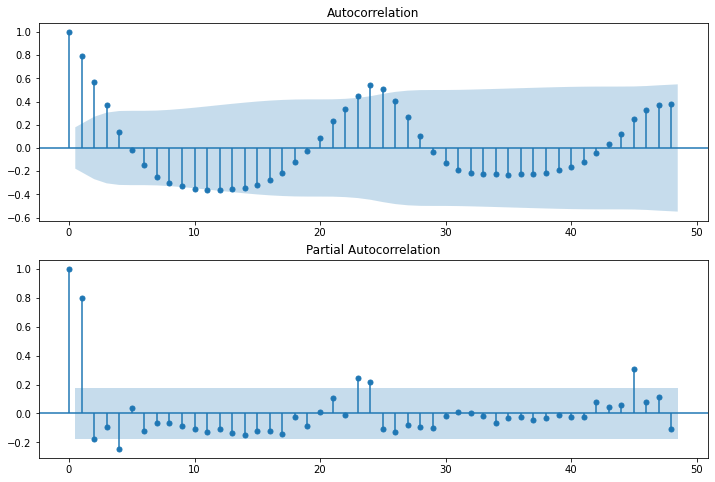

In [39]:
def model_sarima(order, sorder):
    sarima_model = sm.tsa.statespace.SARIMAX(df_all, order = order,
                                            seasonal_order = sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    res = sarima_model.fit()
    
    return order, sorder, res.aic


fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=48,ax=ax1)
plot_pacf(df_all.dropna(),lags=48,ax=ax2)

plt.show()

#(1-4, 0, 2-3)(2-3, 0, 1, 24)

<a id='testing_models_1'></a>

## Testing some models

Here we test some models playing with the autoregressive, moving average
and differencing part (using the above ACF and PCAF plots as reference).

In [29]:
model1 = model_sarima((4, 0, 2), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 1, 2), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 0, 3), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 1, 3), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) X (2, 0, 1, 24); AIC : 1703.407087424707
Model : (4, 1, 2) X (2, 0, 1, 24); AIC : 1680.0922881397005
Model : (4, 0, 3) X (2, 0, 1, 24); AIC : 1705.4367408368212
Model : (4, 1, 3) X (2, 0, 1, 24); AIC : 1681.9015211537035


In [37]:
model1 = model_sarima((1, 0, 1), (3, 1, 2, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

Model : (1, 0, 1) X (3, 1, 2, 24); AIC : 585.7126028190561


In [5]:
p = range(1,5)
d = range(0,2)
q = range(1,4)

P = range(0,4)
D = range(0,2)
Q = range(0,2)

pdq = list(itertools.product(p, d, q))        ## pdq values
pdqs = [(P, D, Q, 24) for P, D, Q in itertools.product(P, D, Q)]      ## pdq values for the seasonal part

In [7]:
## Investigating different models

model_dict = dict()

for order in pdq:
    for seasonal_order in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(df_all, order = order,
                                            seasonal_order = seasonal_order,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        res = sarimax.fit()
        
        print (order, seasonal_order, res.aic)
        model_dict[order, seasonal_order] = res.aic
        

(1, 0, 1) (0, 0, 0, 24) 2908.205614083363
(1, 0, 1) (0, 0, 1, 24) 2320.8594527179357
(1, 0, 1) (0, 1, 0, 24) 2349.7977309700354
(1, 0, 1) (0, 1, 1, 24) 1745.9447455737386
(1, 0, 1) (1, 0, 0, 24) 2340.145533857799
(1, 0, 1) (1, 0, 1, 24) 2314.1157084240185
(1, 0, 1) (1, 1, 0, 24) 1767.6678636681843
(1, 0, 1) (1, 1, 1, 24) 1744.730799080767
(1, 0, 1) (2, 0, 0, 24) 1765.4983310464982
(1, 0, 1) (2, 0, 1, 24) 1767.264076197968
(1, 0, 1) (2, 1, 0, 24) 1185.1986644337621
(1, 0, 1) (2, 1, 1, 24) 1183.9940512549326
(1, 0, 1) (3, 0, 0, 24) 1185.8983985195773
(1, 0, 1) (3, 0, 1, 24) 1180.8216339274343
(1, 0, 1) (3, 1, 0, 24) 583.6958318428337
(1, 0, 1) (3, 1, 1, 24) 583.7129650320212
(1, 0, 2) (0, 0, 0, 24) 2886.886982617418
(1, 0, 2) (0, 0, 1, 24) 2299.642819100672
(1, 0, 2) (0, 1, 0, 24) 2328.2099755754734
(1, 0, 2) (0, 1, 1, 24) 1724.6104401383438
(1, 0, 2) (1, 0, 0, 24) 2342.523456002687
(1, 0, 2) (1, 0, 1, 24) 2292.977315354921
(1, 0, 2) (1, 1, 0, 24) 1770.3965376301385
(1, 0, 2) (1, 1, 1, 2

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (2, 1, 1, 24) 1185.9992888195118
(1, 0, 3) (3, 0, 0, 24) 1187.7475110279152


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (3, 0, 1, 24) 1177.2885852238587
(1, 0, 3) (3, 1, 0, 24) 589.0956256636766


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (3, 1, 1, 24) 589.2091347204451
(1, 1, 1) (0, 0, 0, 24) 2903.6010215064985
(1, 1, 1) (0, 0, 1, 24) 2305.5245612836425
(1, 1, 1) (0, 1, 0, 24) 2327.3790789665527
(1, 1, 1) (0, 1, 1, 24) 6102.703391126676
(1, 1, 1) (1, 0, 0, 24) 2317.083680778521
(1, 1, 1) (1, 0, 1, 24) 2302.9094989378937
(1, 1, 1) (1, 1, 0, 24) 1748.1689961747284
(1, 1, 1) (1, 1, 1, 24) 6010.215222797048
(1, 1, 1) (2, 0, 0, 24) 1751.6614469149301
(1, 1, 1) (2, 0, 1, 24) 1752.3751228579351
(1, 1, 1) (2, 1, 0, 24) 1165.651201062668
(1, 1, 1) (2, 1, 1, 24) 4027.504960411041
(1, 1, 1) (3, 0, 0, 24) 1170.4252088246474
(1, 1, 1) (3, 0, 1, 24) 1165.5998250313507
(1, 1, 1) (3, 1, 0, 24) 563.3722378214443
(1, 1, 1) (3, 1, 1, 24) 1977.8748096573954
(1, 1, 2) (0, 0, 0, 24) 2871.20286679579
(1, 1, 2) (0, 0, 1, 24) 2283.694385478034
(1, 1, 2) (0, 1, 0, 24) 2305.3683870952345
(1, 1, 2) (0, 1, 1, 24) 6018.482059944173
(1, 1, 2) (1, 0, 0, 24) 2328.131624715953
(1, 1, 2) (1, 0, 1, 24) 2270.9513435101103
(1, 1, 2) (1, 1, 0, 24)

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) (3, 0, 1, 24) 1165.0026474807933
(1, 1, 3) (3, 1, 0, 24) 567.8657101363781
(1, 1, 3) (3, 1, 1, 24) 1982.7940496772578
(2, 0, 1) (0, 0, 0, 24) 2909.283695119236
(2, 0, 1) (0, 0, 1, 24) 2322.60617563971
(2, 0, 1) (0, 1, 0, 24) 2351.5881835637333
(2, 0, 1) (0, 1, 1, 24) 1747.0000465611606
(2, 0, 1) (1, 0, 0, 24) 2318.5859440683626
(2, 0, 1) (1, 0, 1, 24) 2316.098008308025
(2, 0, 1) (1, 1, 0, 24) 1745.8650021728258
(2, 0, 1) (1, 1, 1, 24) 1746.1292920604599
(2, 0, 1) (2, 0, 0, 24) 1743.9902479975492
(2, 0, 1) (2, 0, 1, 24) 1745.0005748421113
(2, 0, 1) (2, 1, 0, 24) 1161.9320815098554
(2, 0, 1) (2, 1, 1, 24) 1161.5349818229406
(2, 0, 1) (3, 0, 0, 24) 1162.5439943539354


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (3, 0, 1, 24) 1155.535136954589
(2, 0, 1) (3, 1, 0, 24) 561.8875541942102
(2, 0, 1) (3, 1, 1, 24) 561.8816441520197
(2, 0, 2) (0, 0, 0, 24) 2887.3831076749957
(2, 0, 2) (0, 0, 1, 24) 2300.2468866144955
(2, 0, 2) (0, 1, 0, 24) 2327.3058672265015
(2, 0, 2) (0, 1, 1, 24) 1725.7948435211988
(2, 0, 2) (1, 0, 0, 24) 2320.1223822989286
(2, 0, 2) (1, 0, 1, 24) 2293.9544199501483
(2, 0, 2) (1, 1, 0, 24) 1748.3572106968295
(2, 0, 2) (1, 1, 1, 24) 1724.952961800134
(2, 0, 2) (2, 0, 0, 24) 1745.5337892508815
(2, 0, 2) (2, 0, 1, 24) 1746.8838266149219
(2, 0, 2) (2, 1, 0, 24) 1164.1095361678974
(2, 0, 2) (2, 1, 1, 24) 1161.455295248669
(2, 0, 2) (3, 0, 0, 24) 1164.147629709249


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (3, 0, 1, 24) 1153.9396847190544
(2, 0, 2) (3, 1, 0, 24) 564.4591325354929
(2, 0, 2) (3, 1, 1, 24) 564.7706960105323
(2, 0, 3) (0, 0, 0, 24) 2862.7886831230785
(2, 0, 3) (0, 0, 1, 24) 2276.898149212442
(2, 0, 3) (0, 1, 0, 24) 2306.871958626811
(2, 0, 3) (0, 1, 1, 24) 1704.2710206765062
(2, 0, 3) (1, 0, 0, 24) 2320.6357293672836
(2, 0, 3) (1, 0, 1, 24) 2271.8550044560297
(2, 0, 3) (1, 1, 0, 24) 1750.795894781591
(2, 0, 3) (1, 1, 1, 24) 1703.7142050932703
(2, 0, 3) (2, 0, 0, 24) 1747.1614732204266
(2, 0, 3) (2, 0, 1, 24) 1748.688806909485
(2, 0, 3) (2, 1, 0, 24) 1166.3928834178646


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (2, 1, 1, 24) 1164.009501057521
(2, 0, 3) (3, 0, 0, 24) 1166.0047462398024


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (3, 0, 1, 24) 1156.1140311394388
(2, 0, 3) (3, 1, 0, 24) 566.9428362636064


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (3, 1, 1, 24) 567.3543090108692
(2, 1, 1) (0, 0, 0, 24) 2905.377153880723
(2, 1, 1) (0, 0, 1, 24) 2313.7921156627835
(2, 1, 1) (0, 1, 0, 24) 2328.8909581598127
(2, 1, 1) (0, 1, 1, 24) 6104.366216862758
(2, 1, 1) (1, 0, 0, 24) 2304.266966405469
(2, 1, 1) (1, 0, 1, 24) 2310.895630591182
(2, 1, 1) (1, 1, 0, 24) 1726.0919929242618
(2, 1, 1) (1, 1, 1, 24) 6011.878048533125
(2, 1, 1) (2, 0, 0, 24) 1728.2268252698723
(2, 1, 1) (2, 0, 1, 24) 1729.819626820916
(2, 1, 1) (2, 1, 0, 24) 1142.6918959354389
(2, 1, 1) (2, 1, 1, 24) 3943.847112998466
(2, 1, 1) (3, 0, 0, 24) 1147.5040384343472
(2, 1, 1) (3, 0, 1, 24) 1149.4640671035206
(2, 1, 1) (3, 1, 0, 24) 541.2608454272315
(2, 1, 1) (3, 1, 1, 24) 1894.3829793135685
(2, 1, 2) (0, 0, 0, 24) 2863.025459004009
(2, 1, 2) (0, 0, 1, 24) 2276.1595024849876
(2, 1, 2) (0, 1, 0, 24) 2306.7354882355007
(2, 1, 2) (0, 1, 1, 24) 6019.457890537502
(2, 1, 2) (1, 0, 0, 24) 2296.5719329156896
(2, 1, 2) (1, 0, 1, 24) 2271.4235072770807
(2, 1, 2) (1, 1, 0, 24

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) (3, 0, 1, 24) 1134.5487023751778
(2, 1, 2) (3, 1, 0, 24) 542.5458965817076
(2, 1, 2) (3, 1, 1, 24) 1896.4320961313938
(2, 1, 3) (0, 0, 0, 24) 2841.7833153836496
(2, 1, 3) (0, 0, 1, 24) 2254.963275227057
(2, 1, 3) (0, 1, 0, 24) 2282.7707776172842
(2, 1, 3) (0, 1, 1, 24) 5936.133782205131
(2, 1, 3) (1, 0, 0, 24) 2299.071784747543
(2, 1, 3) (1, 0, 1, 24) 2250.4531480667665
(2, 1, 3) (1, 1, 0, 24) 1730.2910721172746
(2, 1, 3) (1, 1, 1, 24) 5846.345275827774
(2, 1, 3) (2, 0, 0, 24) 1724.2996188137806


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (2, 0, 1, 24) 1726.0073389318402
(2, 1, 3) (2, 1, 0, 24) 1144.6454406323105
(2, 1, 3) (2, 1, 1, 24) 3949.12720803078
(2, 1, 3) (3, 0, 0, 24) 1143.0147732509881


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (3, 0, 1, 24) 1138.4722124987918


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (3, 1, 0, 24) 545.0994149554022
(2, 1, 3) (3, 1, 1, 24) 1898.99519867685
(3, 0, 1) (0, 0, 0, 24) 2887.2048372496674
(3, 0, 1) (0, 0, 1, 24) 2323.4124673521837
(3, 0, 1) (0, 1, 0, 24) 2327.01977407348
(3, 0, 1) (0, 1, 1, 24) 1748.913505766081
(3, 0, 1) (1, 0, 0, 24) 2296.302325962823
(3, 0, 1) (1, 0, 1, 24) 2293.353718514321
(3, 0, 1) (1, 1, 0, 24) 1723.8487699213172
(3, 0, 1) (1, 1, 1, 24) 1724.1216540278938
(3, 0, 1) (2, 0, 0, 24) 1721.9388226814729
(3, 0, 1) (2, 0, 1, 24) 1723.2138097502038
(3, 0, 1) (2, 1, 0, 24) 1139.4884304527177
(3, 0, 1) (2, 1, 1, 24) 1139.5691662501767
(3, 0, 1) (3, 0, 0, 24) 1140.1218379030283
(3, 0, 1) (3, 0, 1, 24) 1133.71134991886
(3, 0, 1) (3, 1, 0, 24) 539.3384689136499


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (3, 1, 1, 24) 540.1110321405199
(3, 0, 2) (0, 0, 0, 24) 2895.6882612188842
(3, 0, 2) (0, 0, 1, 24) 2301.33128357093


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (0, 1, 0, 24) 2327.9466037529246
(3, 0, 2) (0, 1, 1, 24) 1725.2054034072162
(3, 0, 2) (1, 0, 0, 24) 2297.679656737123


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (1, 0, 1, 24) 2294.637683212666
(3, 0, 2) (1, 1, 0, 24) 1723.5213770150422
(3, 0, 2) (1, 1, 1, 24) 1726.3356081747763
(3, 0, 2) (2, 0, 0, 24) 1720.714771765708


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 0, 1, 24) 1722.1220102336686


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 1, 0, 24) 1138.9248299443886


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 1, 1, 24) 1141.51003511138


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (3, 0, 0, 24) 1136.897838337661


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (3, 0, 1, 24) 1139.5404030067127
(3, 0, 2) (3, 1, 0, 24) 541.5985027733248


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (3, 1, 1, 24) 542.6191119392586
(3, 0, 3) (0, 0, 0, 24) 2864.725497052213
(3, 0, 3) (0, 0, 1, 24) 2277.8765798949394
(3, 0, 3) (0, 1, 0, 24) 2308.3666365795198
(3, 0, 3) (0, 1, 1, 24) 1705.9195099271851
(3, 0, 3) (1, 0, 0, 24) 2298.2475065502613
(3, 0, 3) (1, 0, 1, 24) 2273.228535016625
(3, 0, 3) (1, 1, 0, 24) 1728.8140255017822
(3, 0, 3) (1, 1, 1, 24) 1705.423179186094
(3, 0, 3) (2, 0, 0, 24) 1725.4045861175255
(3, 0, 3) (2, 0, 1, 24) 1726.8836122047283
(3, 0, 3) (2, 1, 0, 24) 1141.324764259397


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (2, 1, 1, 24) 1141.6970830769349
(3, 0, 3) (3, 0, 0, 24) 1139.2476932400116


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (3, 0, 1, 24) 1133.6207207785585
(3, 0, 3) (3, 1, 0, 24) 544.4056617120439


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (3, 1, 1, 24) 545.5953168474648
(3, 1, 1) (0, 0, 0, 24) 2872.269184232158
(3, 1, 1) (0, 0, 1, 24) 2308.740379278758
(3, 1, 1) (0, 1, 0, 24) 2307.0501187660666
(3, 1, 1) (0, 1, 1, 24) 6106.366216862758
(3, 1, 1) (1, 0, 0, 24) 2273.060033035274
(3, 1, 1) (1, 0, 1, 24) 2272.3065521456624
(3, 1, 1) (1, 1, 0, 24) 1704.1832087732282
(3, 1, 1) (1, 1, 1, 24) 5928.165504982652
(3, 1, 1) (2, 0, 0, 24) 1699.1479871979939
(3, 1, 1) (2, 0, 1, 24) 1701.124382423537
(3, 1, 1) (2, 1, 0, 24) 1120.4422292737609
(3, 1, 1) (2, 1, 1, 24) 3860.4156540202384
(3, 1, 1) (3, 0, 0, 24) 1120.4137491799054
(3, 1, 1) (3, 0, 1, 24) 1113.1618522884871
(3, 1, 1) (3, 1, 0, 24) 519.3040780064083
(3, 1, 1) (3, 1, 1, 24) 1811.0019347993154
(3, 1, 2) (0, 0, 0, 24) 2864.7128826889366
(3, 1, 2) (0, 0, 1, 24) 2277.8134320272434
(3, 1, 2) (0, 1, 0, 24) 2307.2485022127553
(3, 1, 2) (0, 1, 1, 24) 6021.440472773362
(3, 1, 2) (1, 0, 0, 24) 2274.432804329215
(3, 1, 2) (1, 0, 1, 24) 2273.3299988747776
(3, 1, 2) (1, 1, 0, 2

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (3, 0, 1, 24) 1112.343865194797


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (3, 1, 0, 24) 520.6499974610892
(3, 1, 2) (3, 1, 1, 24) 1813.0435179758597


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (0, 0, 0, 24) 2831.4224840355287


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (0, 0, 1, 24) 2254.4482113375966
(3, 1, 3) (0, 1, 0, 24) 2279.334012866806
(3, 1, 3) (0, 1, 1, 24) 5936.148540702781
(3, 1, 3) (1, 0, 0, 24) 2277.1463187016266
(3, 1, 3) (1, 0, 1, 24) 2251.510264158551
(3, 1, 3) (1, 1, 0, 24) 1706.8393156187099
(3, 1, 3) (1, 1, 1, 24) 5846.360034325429
(3, 1, 3) (2, 0, 0, 24) 1702.250810758434


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (2, 0, 1, 24) 1703.828677807325
(3, 1, 3) (2, 1, 0, 24) 1122.3810957862063
(3, 1, 3) (2, 1, 1, 24) 3864.3541581407358


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (3, 0, 0, 24) 1119.639760342495


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (3, 0, 1, 24) 1121.3676623656934


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (3, 1, 0, 24) 523.1127480977639
(3, 1, 3) (3, 1, 1, 24) 1814.9732367221775
(4, 0, 1) (0, 0, 0, 24) 2862.1568536752825
(4, 0, 1) (0, 0, 1, 24) 2323.226331084927
(4, 0, 1) (0, 1, 0, 24) 2306.8011916159276
(4, 0, 1) (0, 1, 1, 24) 1750.5500455847505
(4, 0, 1) (1, 0, 0, 24) 2273.2633488761862
(4, 0, 1) (1, 0, 1, 24) 2270.92680236839
(4, 0, 1) (1, 1, 0, 24) 1701.9965932707478
(4, 0, 1) (1, 1, 1, 24) 1702.3541377353927
(4, 0, 1) (2, 0, 0, 24) 1700.1435308910907
(4, 0, 1) (2, 0, 1, 24) 1701.6065720573874
(4, 0, 1) (2, 1, 0, 24) 1117.3555003549707
(4, 0, 1) (2, 1, 1, 24) 1117.4923946032654
(4, 0, 1) (3, 0, 0, 24) 1118.15702540472
(4, 0, 1) (3, 0, 1, 24) 1110.7399679033267
(4, 0, 1) (3, 1, 0, 24) 517.2224470741455


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1) (3, 1, 1, 24) 518.3554322046411
(4, 0, 2) (0, 0, 0, 24) 2864.0425819923175
(4, 0, 2) (0, 0, 1, 24) 2301.2283703511494
(4, 0, 2) (0, 1, 0, 24) 2306.8930516502337
(4, 0, 2) (0, 1, 1, 24) 1728.8928836402915
(4, 0, 2) (1, 0, 0, 24) 2276.0736725836277
(4, 0, 2) (1, 0, 1, 24) 2272.6817839184846
(4, 0, 2) (1, 1, 0, 24) 1701.3698205449327


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (1, 1, 1, 24) 1702.3194210551915
(4, 0, 2) (2, 0, 0, 24) 1698.8148580806803


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (2, 0, 1, 24) 1703.407087424707


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (2, 1, 0, 24) 1118.4660425367263


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (2, 1, 1, 24) 1117.9918479603314
(4, 0, 2) (3, 0, 0, 24) 1122.6321448967708


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (3, 0, 1, 24) 1112.932722853972


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (3, 1, 0, 24) 519.3524824703925


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (3, 1, 1, 24) 520.4513302916181
(4, 0, 3) (0, 0, 0, 24) 2866.2391357852293
(4, 0, 3) (0, 0, 1, 24) 2279.8372485029395


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (0, 1, 0, 24) 2303.198785247517
(4, 0, 3) (0, 1, 1, 24) 1707.8787440395424
(4, 0, 3) (1, 0, 0, 24) 2276.748223839365
(4, 0, 3) (1, 0, 1, 24) 2275.161583031177


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (1, 1, 0, 24) 1706.2658970825473
(4, 0, 3) (1, 1, 1, 24) 1707.3851593161949
(4, 0, 3) (2, 0, 0, 24) 1703.9103362998483
(4, 0, 3) (2, 0, 1, 24) 1705.4367408368212
(4, 0, 3) (2, 1, 0, 24) 1118.6974587646082


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (2, 1, 1, 24) 1120.446400243598


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 0, 0, 24) 1117.2777516417545


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 0, 1, 24) 1118.8390405442267


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 1, 0, 24) 522.7761129566496


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 1, 1, 24) 524.02552527435
(4, 1, 1) (0, 0, 0, 24) 2835.7714282273423
(4, 1, 1) (0, 0, 1, 24) 2306.8532846726075
(4, 1, 1) (0, 1, 0, 24) 2284.053456376613
(4, 1, 1) (0, 1, 1, 24) 6104.737234095667
(4, 1, 1) (1, 0, 0, 24) 2256.9937554231774
(4, 1, 1) (1, 0, 1, 24) 2248.7438352680574
(4, 1, 1) (1, 1, 0, 24) 1680.9451689284176
(4, 1, 1) (1, 1, 1, 24) 5840.927663887004
(4, 1, 1) (2, 0, 0, 24) 1676.7072977258701
(4, 1, 1) (2, 0, 1, 24) 1678.664531485719
(4, 1, 1) (2, 1, 0, 24) 1098.2836331210633
(4, 1, 1) (2, 1, 1, 24) 3774.70312015984
(4, 1, 1) (3, 0, 0, 24) 1099.4564942456059
(4, 1, 1) (3, 0, 1, 24) 1101.455397160479
(4, 1, 1) (3, 1, 0, 24) 495.9166755412329
(4, 1, 1) (3, 1, 1, 24) 1726.5840380658938
(4, 1, 2) (0, 0, 0, 24) 2837.5535949875925
(4, 1, 2) (0, 0, 1, 24) 2276.385939215811
(4, 1, 2) (0, 1, 0, 24) 2285.530215769246
(4, 1, 2) (0, 1, 1, 24) 6021.390755704992
(4, 1, 2) (1, 0, 0, 24) 2250.5266769004115
(4, 1, 2) (1, 0, 1, 24) 2249.798113097893
(4, 1, 2) (1, 1, 0, 24) 16

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (3, 0, 1, 24) 1089.6255745028297
(4, 1, 2) (3, 1, 0, 24) 498.2374501259807
(4, 1, 2) (3, 1, 1, 24) 1729.06637242096


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (0, 0, 0, 24) 2831.93851848611
(4, 1, 3) (0, 0, 1, 24) 2254.944181070553


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (0, 1, 0, 24) 2279.824040364112
(4, 1, 3) (0, 1, 1, 24) 5936.588805446721
(4, 1, 3) (1, 0, 0, 24) 2252.51659617308
(4, 1, 3) (1, 0, 1, 24) 2251.8053656608813


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (1, 1, 0, 24) 1684.4160446344765
(4, 1, 3) (1, 1, 1, 24) 5846.800299069364
(4, 1, 3) (2, 0, 0, 24) 1680.167680273514
(4, 1, 3) (2, 0, 1, 24) 1681.9015211537035
(4, 1, 3) (2, 1, 0, 24) 1097.5742321573182
(4, 1, 3) (2, 1, 1, 24) 3779.9148252778377


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (3, 0, 0, 24) 1092.9436132658122


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (3, 0, 1, 24) 1094.6672425424758


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (3, 1, 0, 24) 500.4454033158823
(4, 1, 3) (3, 1, 1, 24) 1731.1348131195289


In [12]:
for model in model_dict:
    if model_dict[model] < 1000:
        print (model, model_dict[model])

#(1-4, 0, 3)(1, 0, 2-3. 24)        

((1, 0, 1), (3, 1, 0, 24)) 583.6958318428337
((1, 0, 1), (3, 1, 1, 24)) 583.7129650320212
((1, 0, 2), (3, 1, 0, 24)) 586.5527571410619
((1, 0, 2), (3, 1, 1, 24)) 586.6488925638929
((1, 0, 3), (3, 1, 0, 24)) 589.0956256636766
((1, 0, 3), (3, 1, 1, 24)) 589.2091347204451
((1, 1, 1), (3, 1, 0, 24)) 563.3722378214443
((1, 1, 2), (3, 1, 0, 24)) 565.6015775309913
((1, 1, 3), (3, 1, 0, 24)) 567.8657101363781
((2, 0, 1), (3, 1, 0, 24)) 561.8875541942102
((2, 0, 1), (3, 1, 1, 24)) 561.8816441520197
((2, 0, 2), (3, 1, 0, 24)) 564.4591325354929
((2, 0, 2), (3, 1, 1, 24)) 564.7706960105323
((2, 0, 3), (3, 1, 0, 24)) 566.9428362636064
((2, 0, 3), (3, 1, 1, 24)) 567.3543090108692
((2, 1, 1), (3, 1, 0, 24)) 541.2608454272315
((2, 1, 2), (3, 1, 0, 24)) 542.5458965817076
((2, 1, 3), (3, 1, 0, 24)) 545.0994149554022
((3, 0, 1), (3, 1, 0, 24)) 539.3384689136499
((3, 0, 1), (3, 1, 1, 24)) 540.1110321405199
((3, 0, 2), (3, 1, 0, 24)) 541.5985027733248
((3, 0, 2), (3, 1, 1, 24)) 542.6191119392586
((3, 0, 3)

<a id='plot_best_sarima'></a>
## Ploting the best SARIMA model
After looping through several models, we plot one
of the best and compare with the dataset

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1220: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


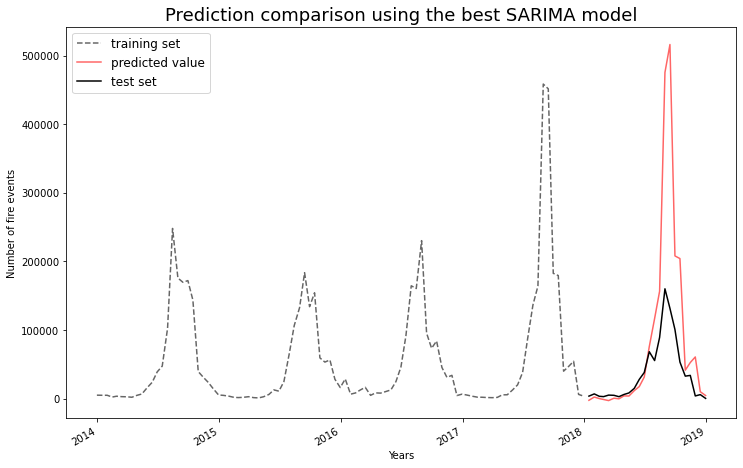

In [9]:
y_train = df_all[:len(df_all) - 24]
y_test = df_all[len(df_all) - 24:]

sarima_model = sm.tsa.statespace.SARIMAX(y_train.riscofogo, order = (1, 0, 1),
                                         seasonal_order = (3, 1, 0, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res = sarima_model.fit()
forecast = res.get_forecast(len(y_test))

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(forecast.predicted_mean, label = 'predicted value', color = 'red', alpha = 0.6)
ax.plot(y_test.riscofogo, label = 'test set', color = 'k')

ax.set_title('Prediction comparison using the best SARIMA model', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')


plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

In [18]:
forecast = res.get_forecast(len(y_test))

rmse = np.sqrt(mean_squared_error(forecast.predicted_mean, y_test))


print(rmse)
print(y_test.riscofogo.mean())

#Which is quite bad, as expected

110781.33965368796
35812.791666666664


## Implementing a rolling forecasting (walk-forward) validation
<a id='walk_forward_val'></a>

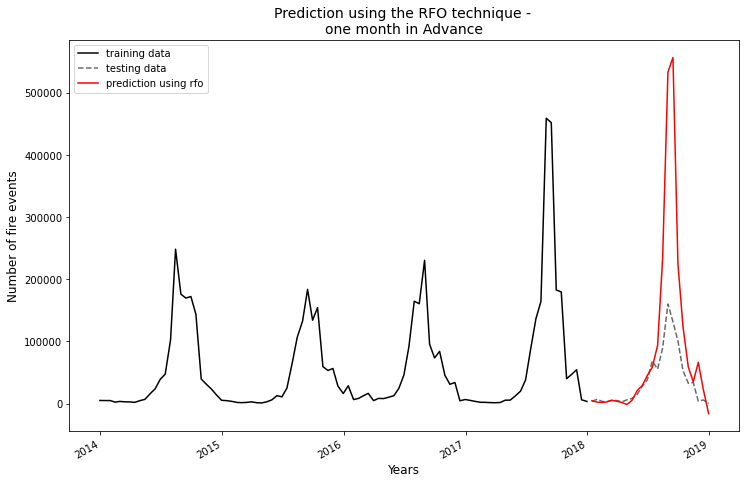

In [11]:
# monthly prediction (walk-forward validation)

predictions = pd.Series(dtype = 'float64')

my_order = (1, 0, 1)
my_sorder = (3, 1, 0, 24)

for data_end in y_test.index:
    y_data_for = df_all[: data_end - relativedelta(months = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    result = model.fit()
    forecast = result.get_forecast(data_end)
    predictions.loc[data_end] = forecast.predicted_mean.loc[data_end]
    
###############################################################################   

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
#ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(predictions, label = 'prediction using rfo', color = 'red')

ax.set_ylabel('Number of fire events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 14)

plt.legend()

plt.show()

In [64]:
rmse = np.sqrt(mean_squared_error(predictions, y_test))


print(rmse)
print(y_test.riscofogo.mean())

123772.13358681426
35812.791666666664


<a id='anomaly_identification'></a>
## Identifying the anomaly(ies) and handling it(them)

As expected, even taking a rolling forecast technique doesn't make any
difference. That's is due to the anomalies present in the timeseries,
let's then take it/them into account.

<a id='qualitative_approach'></a>
### A more qualitative (pedagogical) approach


There are several ways of taking into consideration that there is an anomaly
event within the data set. One of them is to analyse the standard deviation
for a given semimonth (in this case) and analyze how it changes across years.

We might expect a pretty high value for the standard deviation within the fire period
due to the anomaly, due to its lot of variability for different years within this period.

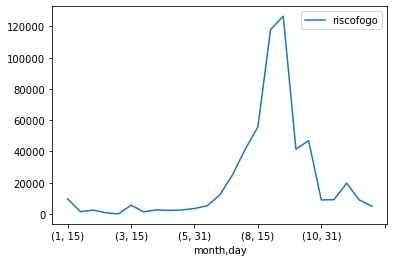

In [15]:
semimonth_deviation = df_all.groupby([df_all.index.month, df_all.index.day]).std(ddof = 0)
semimonth_deviation.index = semimonth_deviation.index.rename(names = ['month', 'day'])

semimonth_deviation.plot()
plt.show()

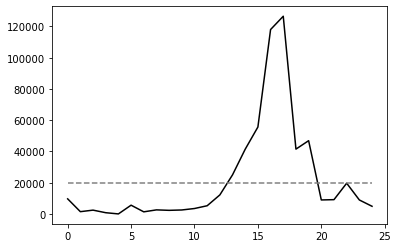

In [16]:
## The anomaly indeed show up within the higher number of fire events, as expected

## Let's set a threshold for this anomaly events

threshold = 20000*np.ones(len(semimonth_deviation))

fig, ax = plt.subplots()

ax.plot(np.array(semimonth_deviation), color = 'k')
ax.plot(threshold, linestyle = '--', c = 'grey')
plt.show()

In [17]:
## Identifying the anomaly period in a table

anomaly_region = semimonth_deviation[semimonth_deviation > 20000].copy().dropna()
anomaly_region

riscofogo
month day               
7     15    25013.565627
      31    41424.733660
8     15    55615.093338
      31   118016.817848
9     15   126522.940504
      30    41472.064060
10    15    46876.899307

<a id='quantitative_approach'></a>

## A more quantitative approach

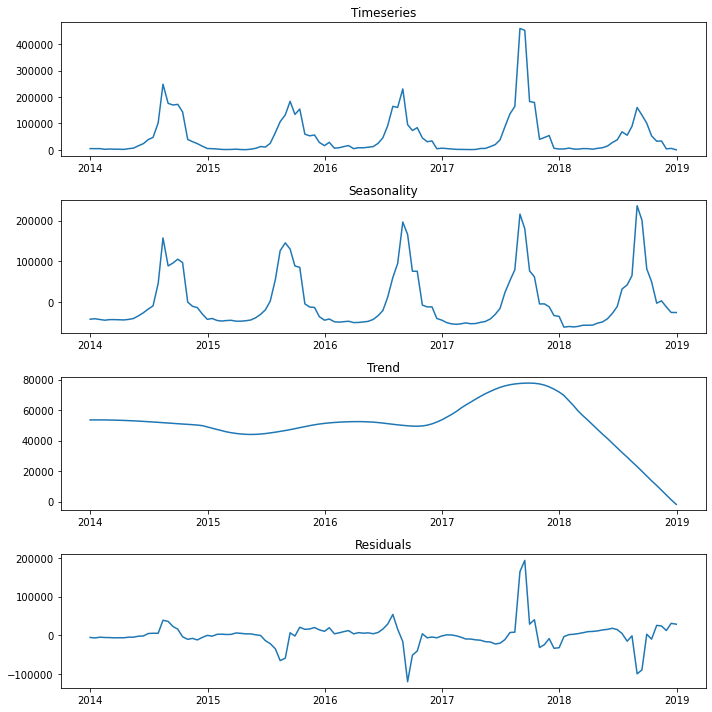

In [13]:
## seasonal trend decomposition 

stl = STL(df_all, period = 24) ## Since we have semimonth data
decomposition = stl.fit()

seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all)
ax1.set_title('Timeseries')
ax2.plot(seasonal)
ax2.set_title('Seasonality')
ax3.plot(trend)
ax3.set_title('Trend')
ax4.plot(residuals)
ax4.set_title('Residuals')


plt.tight_layout()
plt.show()

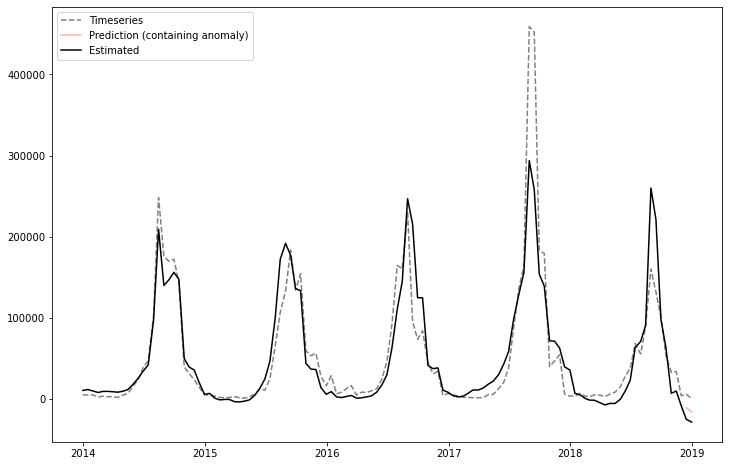

In [14]:
## Getting the difference due to the residuals

plt.figure(figsize = (12,8))
plt.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
plt.plot(forecast.predicted_mean, label = 'Prediction (containing anomaly)', color = 'red', alpha = 0.3)
plt.plot(seasonal+trend, label = "Estimated", c = 'k')
plt.legend()
plt.show()

<a id='spotting_3sigma'></a>

## Brief discussion about the above result

By the above result, we observe that the difference between the estimated curve and
the real timeseries is entirely due to the residuals. What is left for us is to decide
whether these residuals are anomalies or not. For example, for sure in 2017 there is an
anomaly event, as discussed previously. Now what we want is to analyze other mismatches,
for example, like the one in 2014. *Is that an anomaly as well?* To  do so, we need to quantify
it better. Let's then analyze the residuals in greater detail

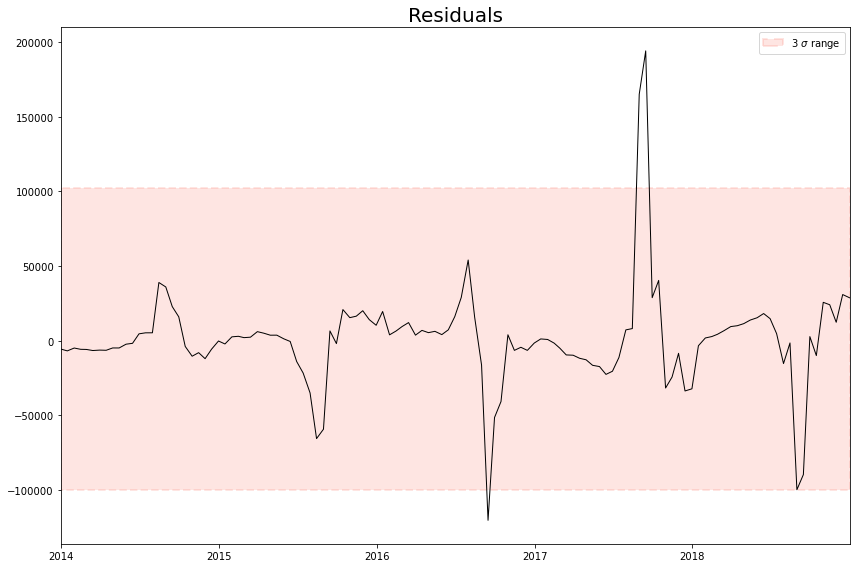

In [15]:
# Working with  the residuals

residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Getting the lower and upper values of it

lower = residuals_mean - 3*residuals_std
upper = residuals_mean + 3*residuals_std

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(residuals, color = 'k', linewidth = 1)

ax.fill_between([df_all.index[0], df_all.index[-1]], lower, upper,
                label = '3 $\sigma$ range',
                color = 'salmon', alpha = 0.2,
                linestyle = '--', linewidth = 2)

ax.set_xlim(df_all.index[0], df_all.index[-1])

ax.set_title('Residuals', fontsize = 20)

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
## And we observe that accordingly, we have two points almost a third one
## which can be considered  as anomalies. Lets show them on the original plot

anomaly_dates = df_all[(residuals > upper) | (residuals < lower)]

anomaly_dates

## Ah okay, the point in 2018 is not an anomaly per se, but within the peak of 2017
## there are two points (end Augst and beginning of September)

,riscofogo
datahora,
2016-09-15,95478.0
2017-08-31,458846.0
2017-09-15,451911.0


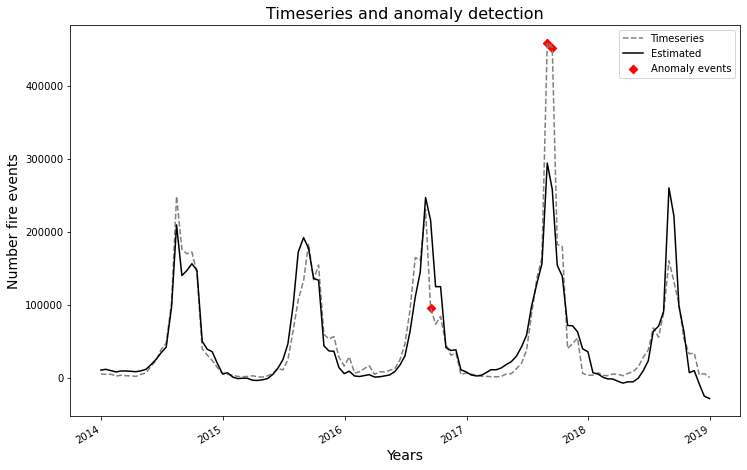

In [18]:
## Plotting the points above

fig, ax = plt.subplots(figsize = (12,8))

ax.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
ax.plot(seasonal+trend, label = "Estimated", c = 'k')
ax.scatter(anomaly_dates.index, anomaly_dates.riscofogo, color='r', marker='D', label = 'Anomaly events')

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number fire events', fontsize = 14)

ax.set_title('Timeseries and anomaly detection', fontsize = 16)

plt.gcf().autofmt_xdate()
plt.legend()

plt.show()

Understanding it better, if we google it "fire events Brazil 2017" We find a bunch of news
saying that brazil got a record in the number of fire events since 1999! For those interestered
might wanna check [this](https://imazon.org.br/imprensa/brasil-termina-2017-com-numero-recorde-de-queimadas-desde-1999/) or [this one](https://g1.globo.com/natureza/noticia/brasil-tem-ano-com-o-maior-numero-de-queimadas-da-historia.ghtml).

It is also quite sad, because by what we have investigated so far we know that 2019 was
also a record and 2020 broke it again. So, within the near future these events which were
anomaly so far might not be anymore and may be the new reality of our biomes.

Now let's get back and include the fact that these peaks were indeed anomalies and make
a new prediction for 2018. *Okay, but how to do so?* The idea is simple: since we have
already identified the anomalies we are going to built a new dataset where the anomalies
are replaced by the mean value of the regular data (at the same date, of course). We then are going
to use these new data, where the anomaly is corrected, to make a new model for the prediction
in 2018.
<a id='new_dataset'></a>

In [19]:
df_all_ac = df_all.copy() #ac stands for anomaly corrected
y_train_ac = y_train.copy()

for date in anomaly_dates.index:
    condition = (y_train_ac.index.day == date.day) & (y_train_ac.index.month == date.month) & (y_train_ac.index.year != date.year)
    corrected_value = y_train_ac[condition].mean() # take the mean for of previous years
    y_train_ac.loc[date].iat[0] = corrected_value  # change the anomaly event

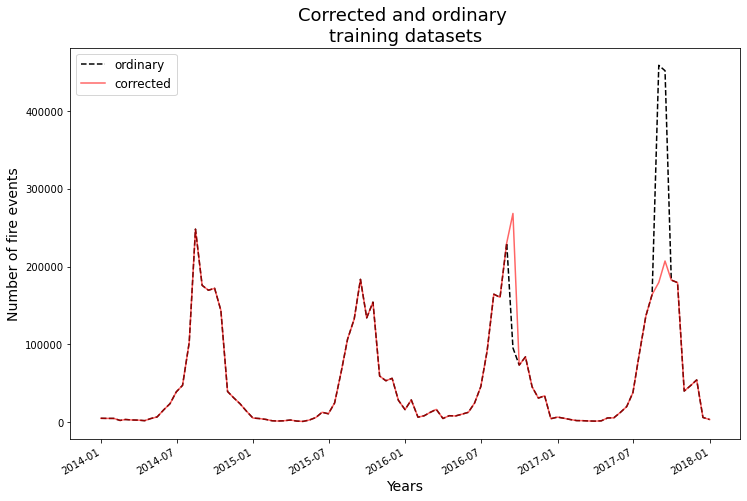

In [20]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(y_train, linestyle = '--', color = 'k', label = 'ordinary')
ax.plot(y_train_ac, color = 'red', label = 'corrected', alpha = 0.6)

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_title('Corrected and ordinary \ntraining datasets', fontsize = 18)

plt.gcf().autofmt_xdate()
plt.legend(fontsize = 12)

plt.show()

## Summing up and next steps

Now we have corrected the anomaly effect in a new dataset and we are going to use it to predict
2018 events. For doing so, let's follow similar steps to those ones at the beginning and get the
best model

ADF statistics : -5.091595439391679
p-value : 1.4574902158878894e-05


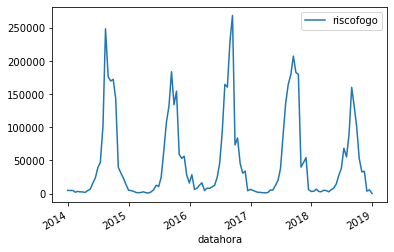

In [21]:
df_all_ac = pd.concat([y_train_ac, y_test])

stationary_test = adfuller(df_all_ac.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

df_all_ac.plot()
plt.show()

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


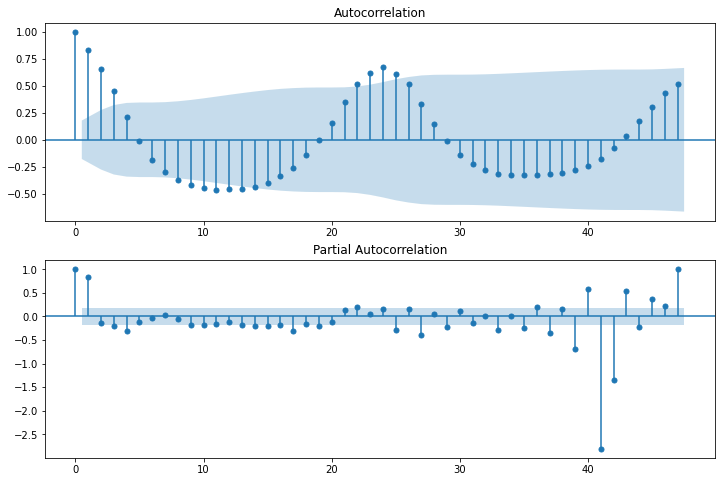

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax1)
plot_pacf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax2)

plt.show()

By analyzing the PACF and the ACF we get the the seasonal ARIMA parameters
$p = 1-3$, $d = 0$, $q = 1-3$, $P = 2$ or more, $D = 1$ and $Q = 1$. Let's check
which one is the best model.

In [40]:
model1 = model_sarima((1, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 1) X (2, 1, 1, 24); AIC : 1183.9940512549326
Model : (2, 0, 1) X (2, 1, 1, 24); AIC : 1161.5349818229406
Model : (3, 0, 1) X (2, 1, 1, 24); AIC : 1139.5691662501767


In [41]:
model1 = model_sarima((1, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 2) X (2, 1, 1, 24); AIC : 1186.2507826199153
Model : (2, 0, 2) X (2, 1, 1, 24); AIC : 1161.455295248669


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) X (2, 1, 1, 24); AIC : 1141.51003511138


In [42]:
model1 = model_sarima((1, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 2) X (3, 1, 1, 24); AIC : 586.6488925638929
Model : (2, 0, 2) X (3, 1, 1, 24); AIC : 564.7706960105323


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) X (3, 1, 1, 24); AIC : 542.6191119392586


In [45]:
model1 = model_sarima((1, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) X (3, 1, 1, 24); AIC : 589.2091347204451


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) X (3, 1, 1, 24); AIC : 567.3543090108692


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) X (3, 1, 1, 24); AIC : 545.5953168474648


In [46]:
model1 = model_sarima((1, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 587.3130351677412
Model : (2, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 565.5311913975586
Model : (3, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 543.9552670332112


<a id='new_prediction'></a>
## Prediction using the above method and the new training data

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


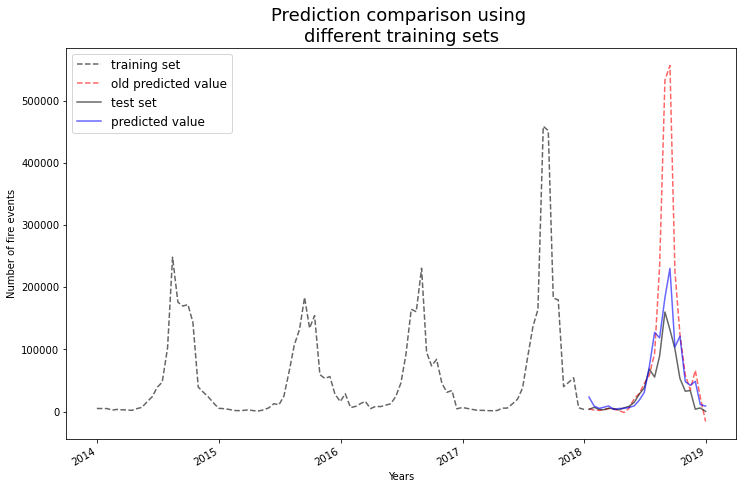

In [73]:
#y_train_ac = df_all_ac[:len(df_all) - 24]
#y_test_ac = df_all_ac[len(df_all) - 24:]

#diff = df_all_ac - df_all_ac.shift(24)

sarima_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = (1, 0, 3),
                                         seasonal_order = (3, 0, 2, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res_ac = sarima_model_ac.fit()
forecast_ac = res_ac.get_forecast(len(y_test))


fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(predictions, label = 'old predicted value', color = 'red', alpha = 0.6, linestyle = '--')
ax.plot(y_test.riscofogo, label = 'test set', color = 'k', alpha = 0.6)

ax.plot(forecast_ac.predicted_mean, label = 'predicted value', color = 'blue', alpha = 0.6)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

# Implementing the walk-forward validation

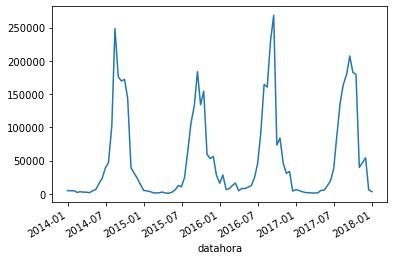

In [87]:
#anomaly_dates = anomaly_dates[anomaly_dates.index.year > 2016]

y_train_ac.riscofogo.plot()
plt.show()

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


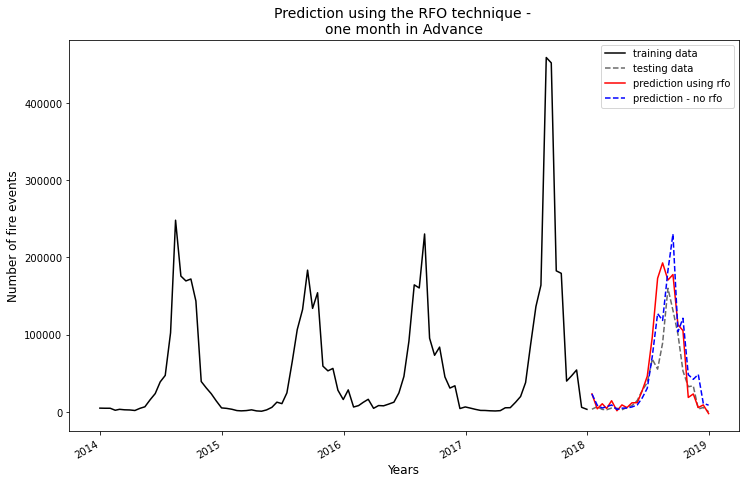

In [57]:
# monthly prediction

predictions_rfo_ac = pd.Series(dtype = 'float64')

my_order = (1, 0, 3)
my_sorder = (2, 0, 1, 24)

for data_end in y_test.index:
    y_data_for = df_all_ac[: data_end - relativedelta(months = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    result = model.fit()
    forecast_rfo_ac = result.get_forecast(data_end)
    predictions_rfo_ac.loc[data_end] = forecast_rfo_ac.predicted_mean.loc[data_end]
    
###############################################################################   

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions_rfo_ac, label = 'prediction using rfo', color = 'red')
ax.plot(forecast_ac.predicted_mean, label = 'prediction - no rfo', color = 'blue', linestyle = '--')

ax.set_ylabel('Number of fire events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 14)

plt.legend()

plt.show()

In [72]:
rmse_ac = np.sqrt(mean_squared_error(forecast_ac.predicted_mean, y_test))
rmse_ac_rfo = np.sqrt(mean_squared_error(predictions_rfo_ac, y_test))

print(rmse_ac_rfo)
print(y_test.riscofogo.mean())
print (' ')
print("RMSE improvement after anomaly handling: {}%".format(100*round(rmse/rmse_ac_rfo, 4)))

36245.21031634289
35812.791666666664
 
RMSE improvement after anomaly handling: 341.49%


<a id='rmse_comparison'></a>